# Differentially private federated GAN: an ablation study

The checkpoints are available via the [link](https://www.dropbox.com/sh/6b7pydwwokdtbmw/AAAHzI62wTfumSlaCfI0ikDta?dl=0).

## Setup 

### Imports

In [48]:
import os
from glob import glob
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

### Environment

In [5]:
EXPERIMENT_DIR = "../experiments"

## Utilities

In [98]:
from itertools import groupby


def nearby_groups(arr, tol_digits=2):
    # split up sorted input array into groups if they're similar enough
    for (_, grp) in groupby(arr, lambda x: round(x, tol_digits)):
        # yield value from group that is closest to an integer
        yield sorted(grp, key=lambda x: abs(round(x) - x))[0]

In [88]:
checkpoints = glob("{}/*".format(EXPERIMENT_DIR))
print("Example experiment checkpoint: {}".format(checkpoints[0]))

Example experiment checkpoint: ../experiments/1000_10_6_6_10_10_True_0.23944106906446763_0.8513794064392131


For the experiment checkpoint `1000_10_6_6_10_10_True_0.23944106906446763_0.8513794064392131`, the options are:

- the number of rounds: `1000`
- the number of clients per round: `10`
- the number of steps to train the client discriminator: `6`
- the number of steps to train the server generator: `6`
- the number of rounds after which the evaluation is run: `10`
- the number of rounds after which the sample images are saved: `10`
- whether to use differential privacy: `True`
- the $L_2$ norm gradient clipping value for differential privacy: `0.23944106906446763`
- the noise multiplier for added noise: `0.8513794064392131`


In [89]:
characteristic_images

,dp_l2_norm_clip,dp_noise_multiplier,image_path


In [141]:
def plot_characteristic_img(
    img_round, zoom=0.2, alpha=0.8, round_tolerance=20, save=False
):
    characteristic_images = {
        "dp_l2_norm_clip": [],
        "dp_noise_multiplier": [],
        "image_path": [],
    }

    checkpoints_info = {
        "dp_l2_norm_clip": [],
        "dp_noise_multiplier": [],
    }

    for checkpoint in checkpoints:
        dp_l2_norm_clip, dp_noise_multiplier = tuple(checkpoint.split("_")[-2:])

        dp_l2_norm_clip = float(dp_l2_norm_clip)
        dp_noise_multiplier = float(dp_noise_multiplier)

        checkpoints_info["dp_l2_norm_clip"].append(dp_l2_norm_clip)
        checkpoints_info["dp_noise_multiplier"].append(dp_noise_multiplier)

        candidates = []

        for image_path in glob("{}/**/*.png".format(checkpoint), recursive=True):
            image_round = int(image_path[:-4].split("_")[-1])

            if 0 <= img_round - image_round <= round_tolerance:
                candidates.append((image_round, image_path))
        if len(candidates) > 0:
            characteristic_images["dp_l2_norm_clip"].append(float(dp_l2_norm_clip))
            characteristic_images["dp_noise_multiplier"].append(
                float(dp_noise_multiplier)
            )
            characteristic_images["image_path"].append(
                max(candidates, key=itemgetter(0))[1]
            )

    characteristic_images = pd.DataFrame(characteristic_images)

    sorted_dp_l2_norm_clip = list(
        nearby_groups(np.sort(checkpoints_info["dp_l2_norm_clip"]), tol_digits=1)
    )
    sorted_dp_noise_multiplier = list(
        nearby_groups(np.sort(checkpoints_info["dp_noise_multiplier"]), tol_digits=1)
    )

    fig, ax = plt.subplots(dpi=150)

    ax.update_datalim(
        np.column_stack(
            [
                characteristic_images.dp_l2_norm_clip,
                characteristic_images.dp_noise_multiplier,
            ]
        )
    )
    for idx, row in characteristic_images.iterrows():
        dp_l2_norm_clip = row["dp_l2_norm_clip"]
        dp_noise_multiplier = row["dp_noise_multiplier"]
        image_path = row["image_path"]
        im = OffsetImage(plt.imread(image_path), zoom=zoom, alpha=alpha)
        ab = AnnotationBbox(im, (dp_l2_norm_clip, dp_noise_multiplier), frameon=False)
        ax.add_artist(ab)
    ax.autoscale()
    ax.set_xticks(sorted_dp_l2_norm_clip)
    ax.set_yticks(sorted_dp_noise_multiplier)
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.box(False)
    plt.xticks(rotation=90)
    ax.tick_params(axis="both", labelsize=6)
    plt.ylabel("dp_noise_multiplier", fontsize=8)
    plt.xlabel("dp_l2_norm_clip", fontsize=8)
    plt.title(
        "Characteristic images for rounds {}-{}".format(
            img_round - round_tolerance, img_round
        ),
        fontsize=9,
    )
    if save:
        plt.savefig("characteristic_{}.png".format(img_round), bbox_inches="tight")
    plt.show()

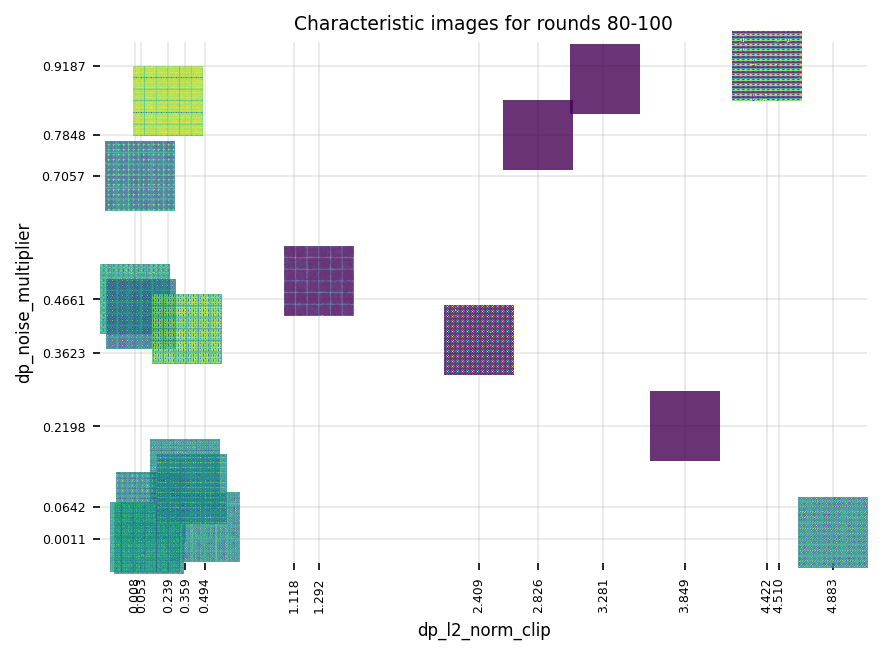

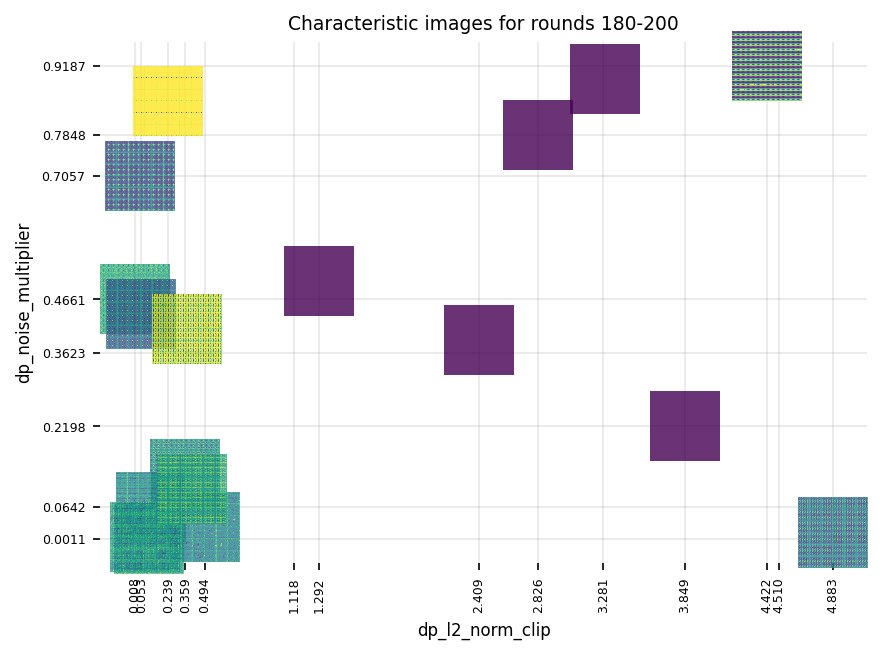

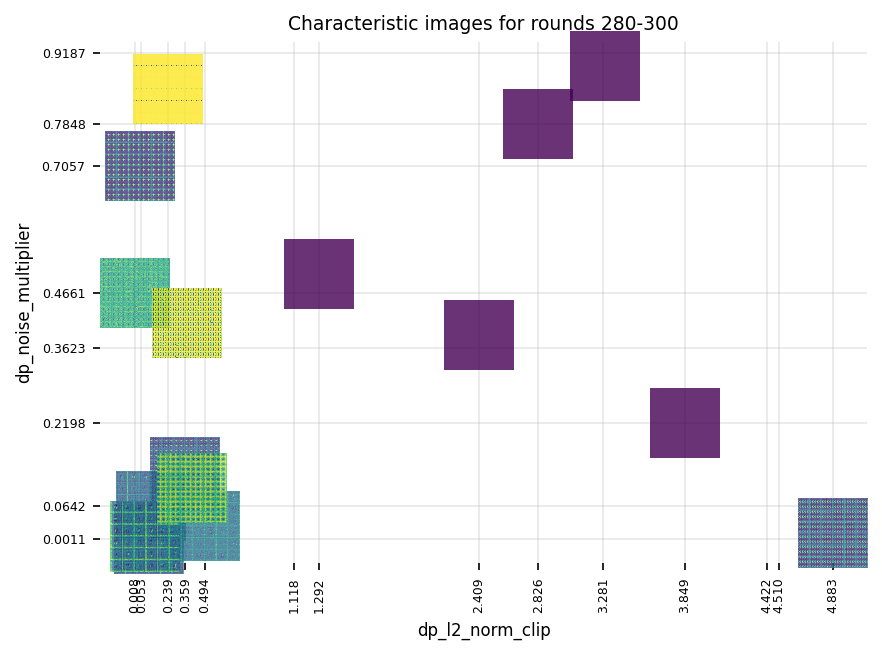

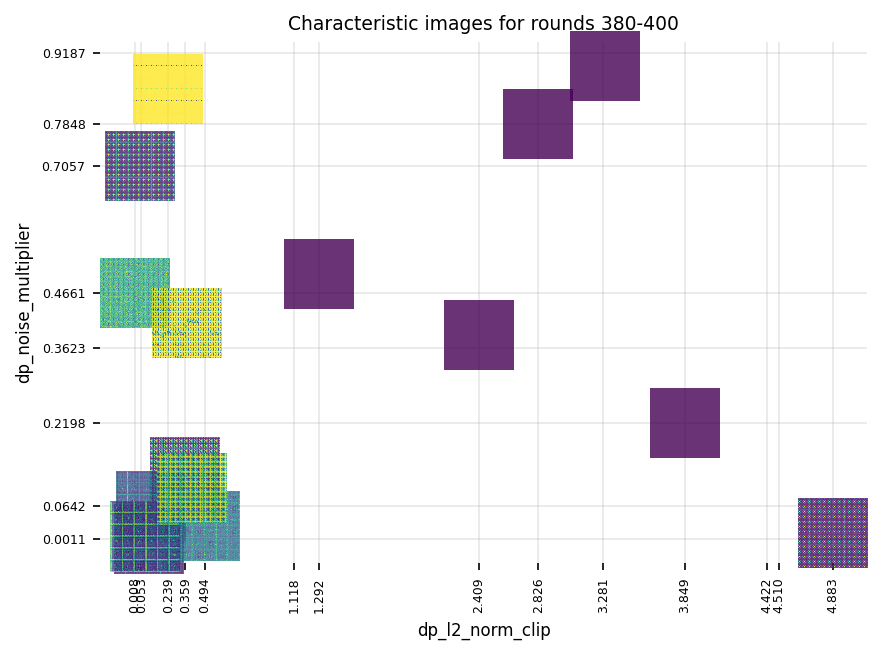

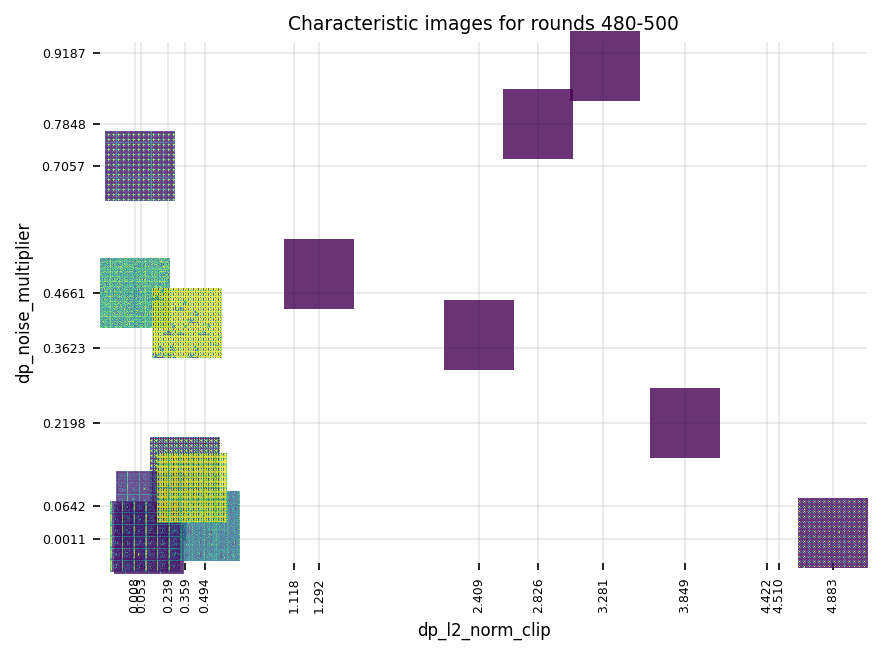

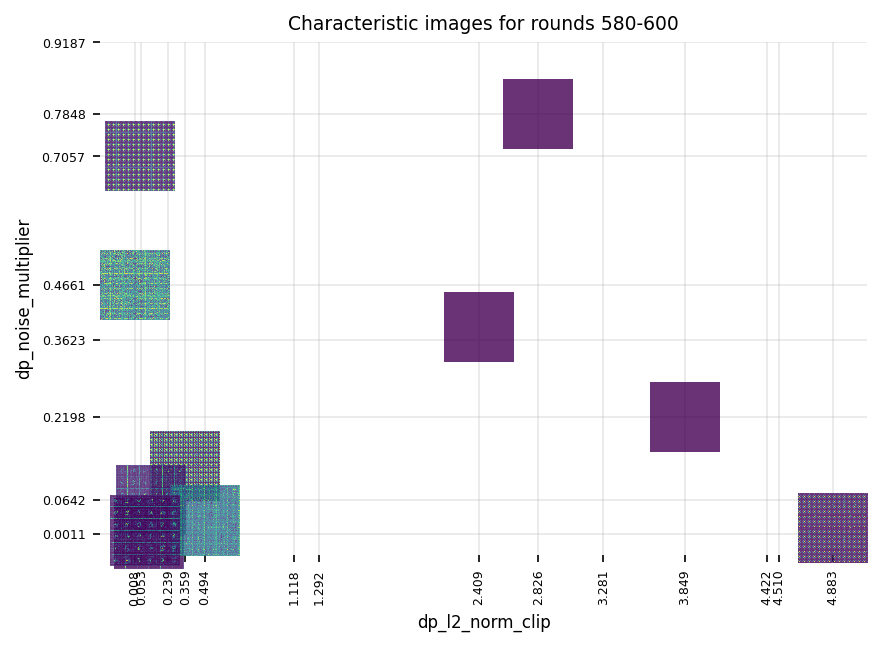

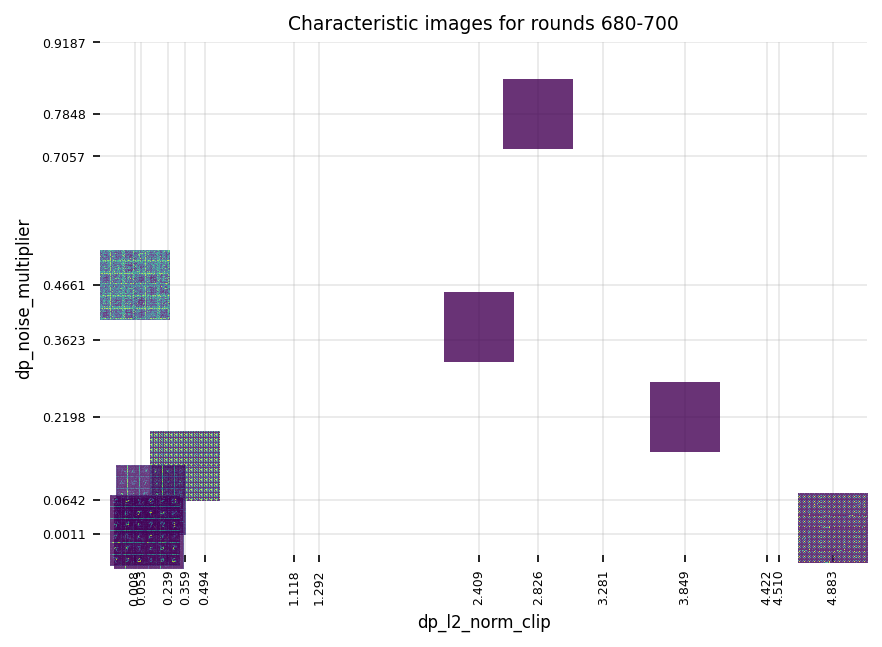

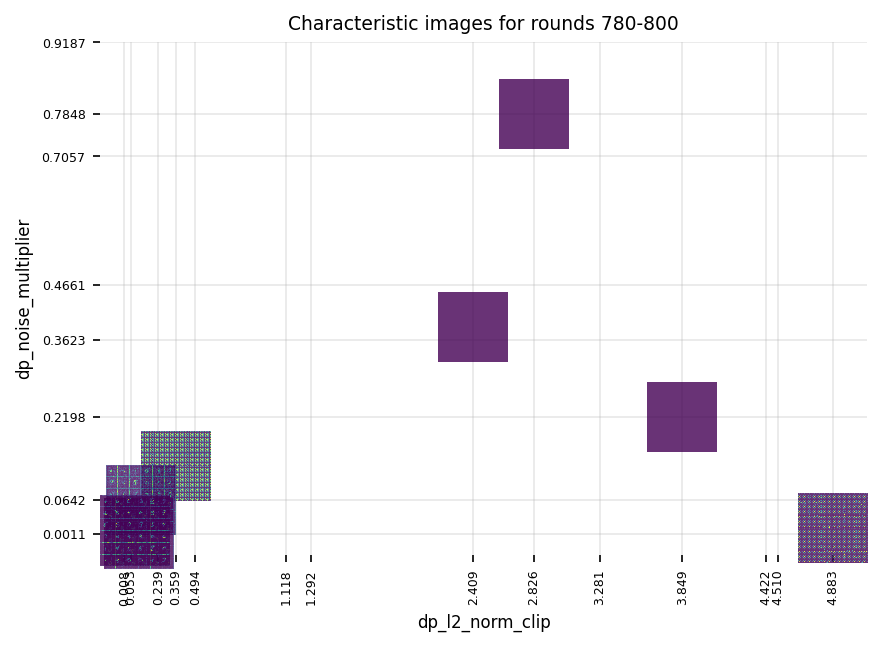

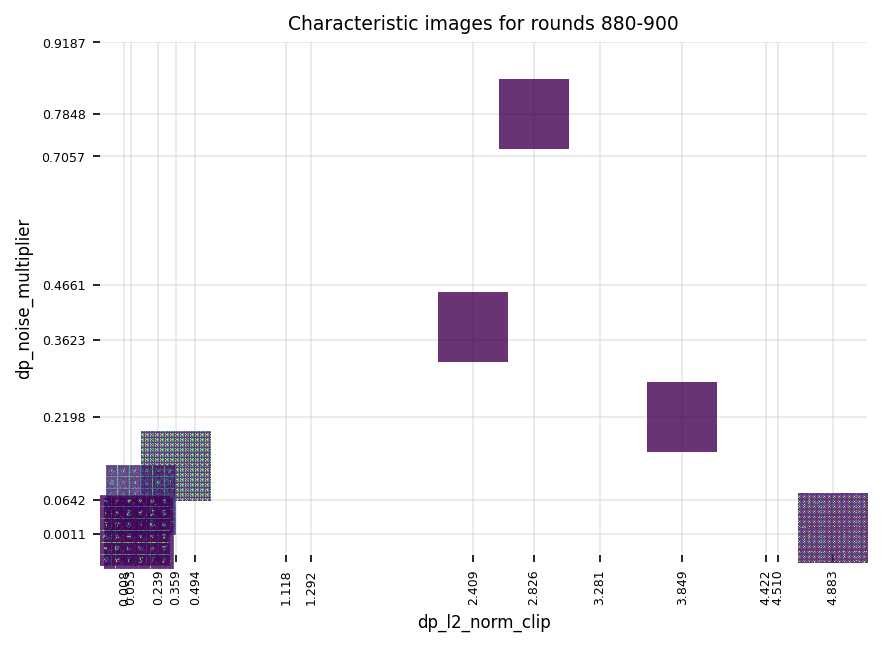

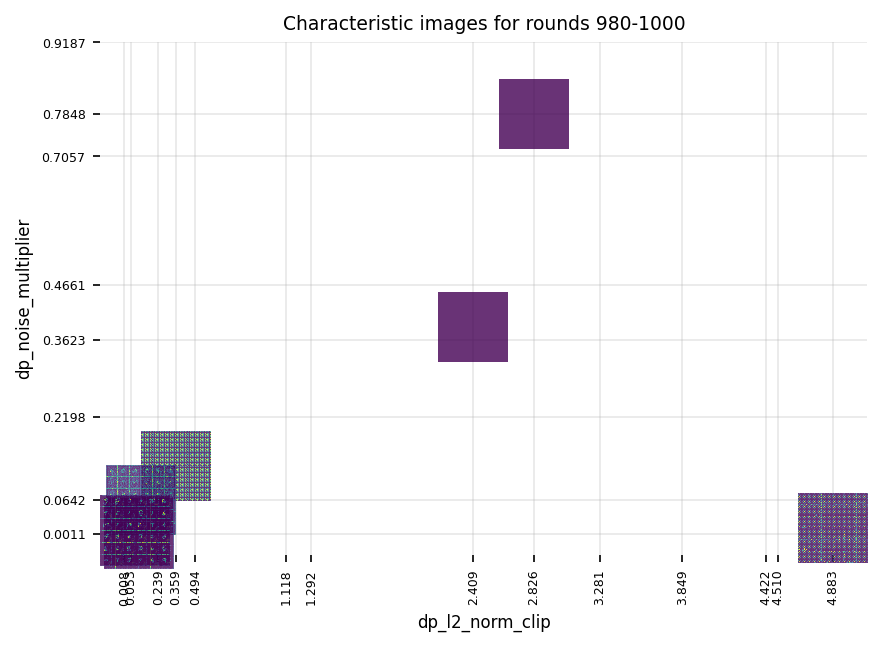

In [142]:
for img_round in np.linspace(100, 1000, 10, dtype=int):
    plot_characteristic_img(img_round, save=True)